<a href="https://colab.research.google.com/github/Nathan-Bush46/AIPI-Interpretable-ML/blob/main/assignments/mechanistic_interp_starter.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Nathan Bush
I changed the task to counting 1s in strings with letters, digits, and punctuation of length 8. Below starts off similarly to your notebook but then goes in depth on how one neuron is used to control for large ASCII character values.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

### Data Generation

In [66]:
import random
import string
import torch


# generate sequences with 1 or random ASCII chars (replacing 0)
def generate_char_data(n_samples=10000, seq_length=8):
    X = []
    y = []
    chars = string.ascii_letters + string.digits + string.punctuation
    for _ in range(n_samples):
        seq = []
        ones = 0
        for _ in range(seq_length):
            bit = random.choice([0, 1])
            if bit == 1:
                seq.append(1)
                ones += 1
            else:
                seq.append(random.choice(chars))   # ASCII char
        X.append(seq)
        y.append(ones)

    return X, torch.tensor(y, dtype=torch.long)


# encode: 1 stays 1, chars become ord(char)
def encode_seq(X_raw):
    encoded = []
    for seq in X_raw:
        encoded.append([v if v == 1 else ord(v) for v in seq])
    return torch.tensor(encoded, dtype=torch.float) # note I need floats for MLP

seq_length = 8
n_classes = seq_length + 1
X_train_raw, y_train = generate_char_data(2000, seq_length)
X_val_raw, y_val = generate_char_data(500, seq_length)
X_train = encode_seq(X_train_raw)
X_val = encode_seq(X_val_raw)


### Build a Tiny MLP (multilayer perceptron) Model

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Updated Model for Regression
class CountingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar

    def forward(self, x):
        h = F.leaky_relu(self.fc1(x)) # a bit faster
        out = self.fc2(h)
        return out, h  # for interpretability

# Instantiate model
model = CountingMLP(input_dim=seq_length, hidden_dim=10)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(8000):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")


CountingMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.052020929753780365
Validation MAE: 0.17
Rounded Accuracy: 0.97


### Print Activations of a sample input

In [99]:
with torch.no_grad():
    sample_input = encode_seq([[1, '0', 1, 'd', 1, 1, 'b', '2']])
    logits, hidden = model(sample_input)
print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")


Sample Input: tensor([[  1.,  48.,   1., 100.,   1.,   1.,  98.,  50.]])
Hidden Layer Activations: tensor([[-1.1347e+00,  1.4044e+00,  6.0629e+00, -1.1933e-01, -2.0280e-02,
         -1.9737e-03, -5.6570e-02,  1.7519e+01,  4.3947e+00, -2.5700e-01]])
Output Logits: tensor([[3.9010]])
Rounded Prediction: 4


### Plot hidden activations across different numbers of 1s as input

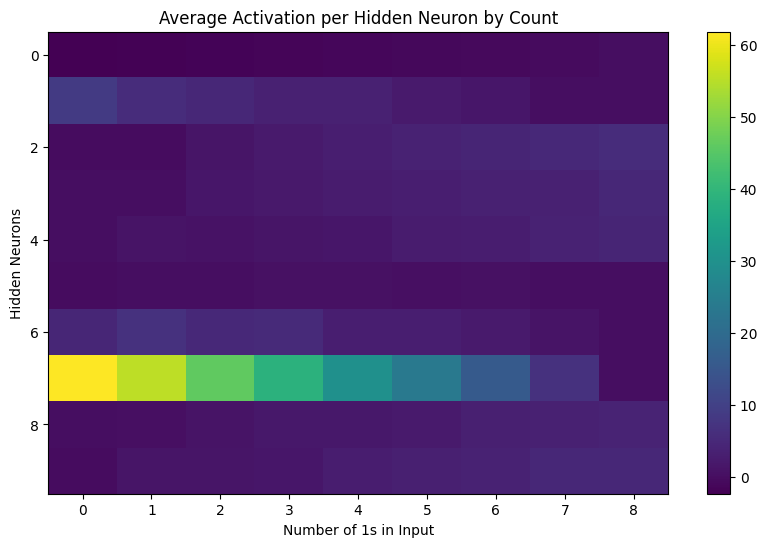

In [100]:
model.eval()
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, model.fc1.out_features))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Count")
plt.colorbar()
plt.show()


Here we see a *Monotonic Trend* for neuron 7. We will now see the effect or removeing each neruon on test data then on full valdation data



### Neuron Ablation (Single Data)

In [115]:
# Sample input to test
sample_raw = [[1, 'a', 1, 'd', 1, 1, 'b', '2']]
test_input = encode_seq(sample_raw).float()
true_count = sample_raw[0].count(1)


# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

# Zero out one neuron in the hidden layer 
neuron_to_zero = 7

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h = F.relu(model.fc1(test_input))
    h[:, neuron_to_zero] = 0  # zeroing neuron
    modified_output = model.fc2(h)
    modified_pred = modified_output.item()


print(f"True count: {true_count}")
print(f"Prediction (normal): {baseline_pred:.2f}")
print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred:.2f}")

delta = modified_pred - baseline_pred
if delta > 0:
    print(f"➕ Prediction increased by {delta:.2f}")
elif delta < 0:
    print(f"➖ Prediction decreased by {abs(delta):.2f}")
else:
    print("⚖️ No change in prediction")


True count: 4
Prediction (normal): 3.91
Prediction (with neuron 7 zeroed): 6.42
➕ Prediction increased by 2.51


It seems is likley that neuron 7 plays an important functional role in the model’s decision, but I will now test on full valdation set for each neuron

### Neuron Ablation (sweep of neurons)

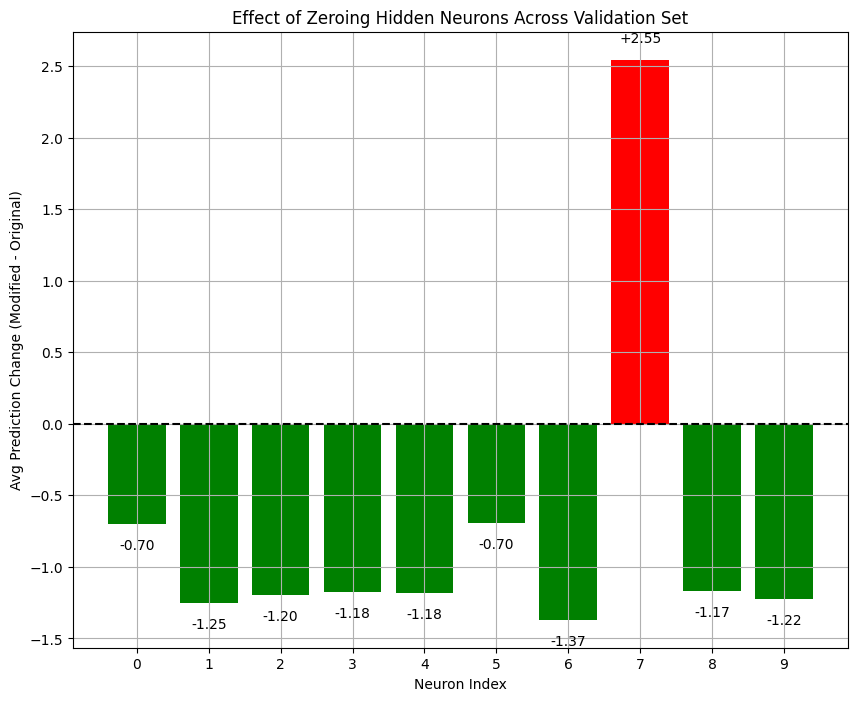

Neuron 0 → Avg prediction decreased by 0.70
Neuron 1 → Avg prediction decreased by 1.25
Neuron 2 → Avg prediction decreased by 1.20
Neuron 3 → Avg prediction decreased by 1.18
Neuron 4 → Avg prediction decreased by 1.18
Neuron 5 → Avg prediction decreased by 0.70
Neuron 6 → Avg prediction decreased by 1.37
Neuron 7 → Avg prediction increased by 2.55
Neuron 8 → Avg prediction decreased by 1.17
Neuron 9 → Avg prediction decreased by 1.22


In [ ]:
model.eval()
# Baseline predictions for full validation set
with torch.no_grad():
    baseline_out, _ = model(X_val)
    baseline_preds = baseline_out.squeeze()

neuron_indices = list(range(model.fc1.out_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(X_val))
        h[:, i] = 0  # zero neuron i for all samples
        mod_out = model.fc2(h).squeeze()
        delta = (mod_out - baseline_preds).mean().item()
        signed_deltas.append(delta)

plt.figure(figsize=(10, 8))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Avg Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing Hidden Neurons Across Validation Set")
plt.grid(True)

for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.1 if d > 0 else -0.1), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top')

plt.show()

for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} → Avg prediction {direction} by {abs(d):.2f}")


#### **What does the sweep of neuron ablations tell us?**
looks like Neuron 7 is an the only inhibitory neuron as remving it made predction go way up. All other neurons push the prediction up on average.

# One more check

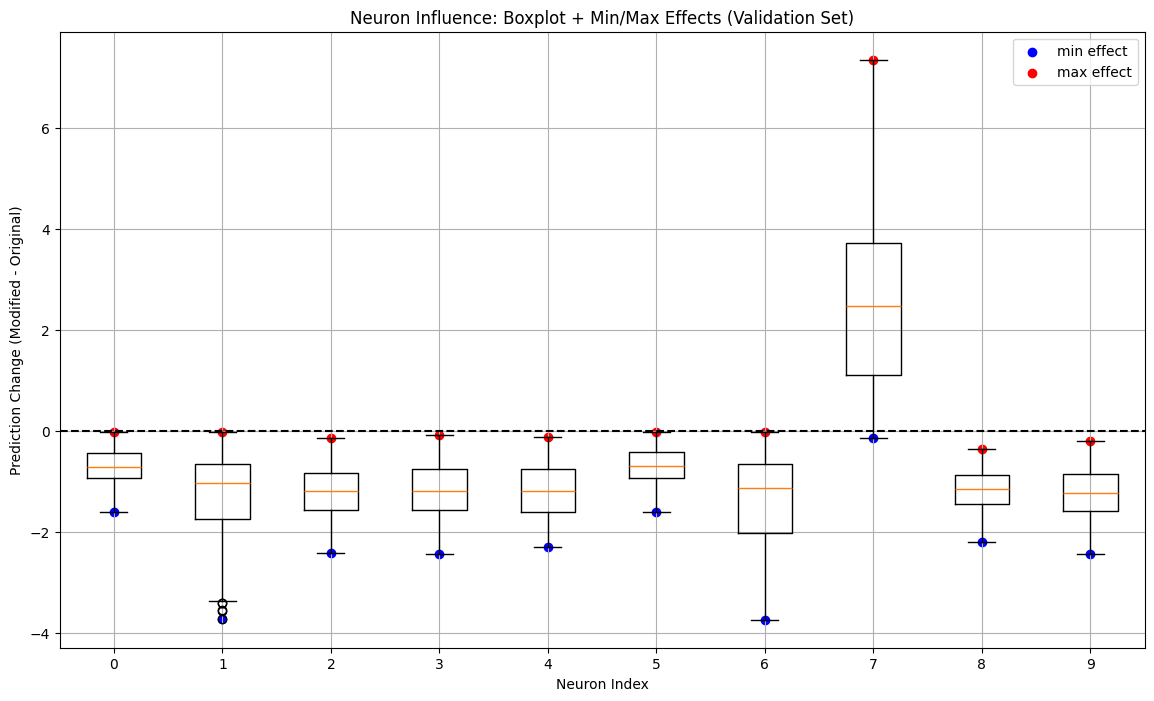

Neuron 0: min -1.60, max -0.01
Neuron 1: min -3.73, max -0.01
Neuron 2: min -2.43, max -0.14
Neuron 3: min -2.44, max -0.09
Neuron 4: min -2.29, max -0.11
Neuron 5: min -1.60, max -0.01
Neuron 6: min -3.74, max -0.01
Neuron 7: min -0.15, max +7.35
Neuron 8: min -2.19, max -0.35
Neuron 9: min -2.44, max -0.21


In [ ]:
## used chatgpt to edit this graph for box plots
model.eval()
with torch.no_grad():
    baseline_out, _ = model(X_val)
    baseline_preds = baseline_out.squeeze()

neuron_indices = list(range(model.fc1.out_features))
all_deltas = []
min_deltas = []
max_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(X_val))
        h[:, i] = 0
        mod_out = model.fc2(h).squeeze()
        deltas = (mod_out - baseline_preds)
        all_deltas.append(deltas.cpu().numpy())
        min_deltas.append(deltas.min().item())
        max_deltas.append(deltas.max().item())

plt.figure(figsize=(14, 8))

plt.boxplot(all_deltas, positions=neuron_indices, widths=0.5)

plt.scatter(neuron_indices, min_deltas, color='blue', label='min effect')
plt.scatter(neuron_indices, max_deltas, color='red', label='max effect')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Neuron Influence: Boxplot + Min/Max Effects (Validation Set)")
plt.grid(True)
plt.legend()
plt.xticks(neuron_indices)

plt.show()

for i in neuron_indices:
    print(f"Neuron {i}: min {min_deltas[i]:+.2f}, max {max_deltas[i]:+.2f}")


Here I used box plots and the pattern is consistent. Every neuron but 7 decreases the prediction when removed, showing they all act as positive contributors to the count. Neuron 7 is the lone exception, with a strong positive max effect, meaning it normally regulates the output.

This may be needed as as some numbers are large and need to be supressed so this Neuron  takes care of them

# I will test that fast now

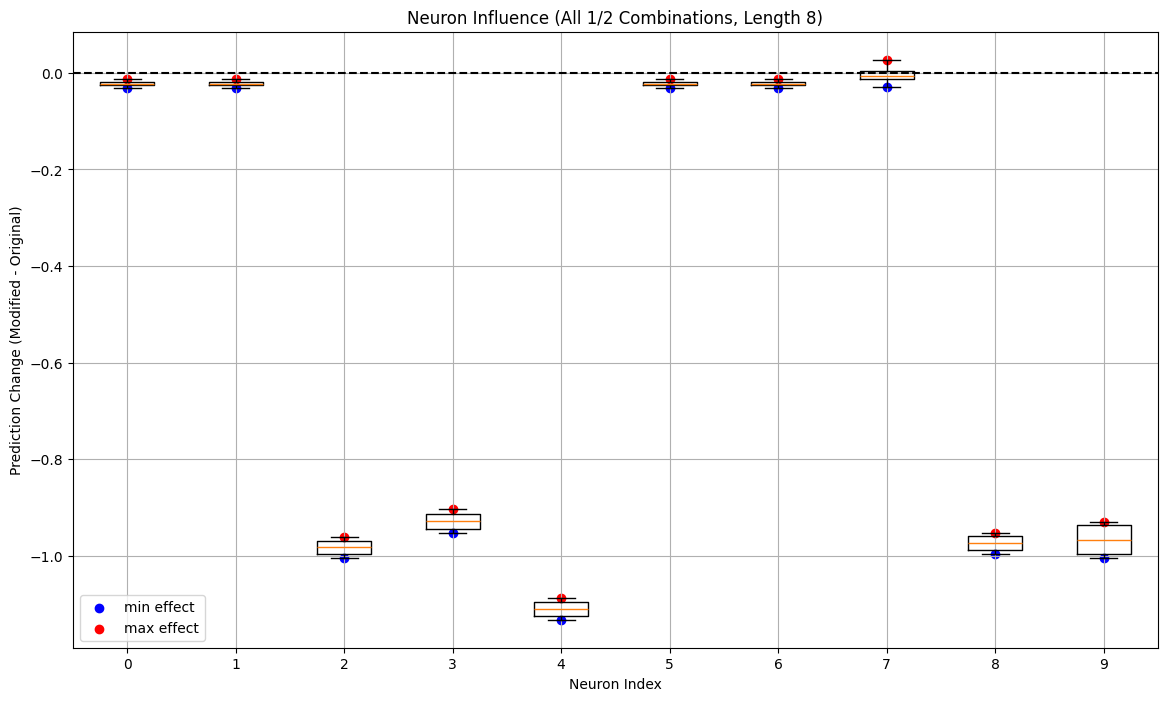

Neuron 0: min -0.03, max -0.01
Neuron 1: min -0.03, max -0.01
Neuron 2: min -1.00, max -0.96
Neuron 3: min -0.95, max -0.90
Neuron 4: min -1.13, max -1.09
Neuron 5: min -0.03, max -0.01
Neuron 6: min -0.03, max -0.01
Neuron 7: min -0.03, max +0.03
Neuron 8: min -1.00, max -0.95
Neuron 9: min -1.00, max -0.93


In [ ]:
import itertools
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# all combinations of length 8 using values {1,2}
combos = list(itertools.product([1,2], repeat=seq_length))
X_small = torch.tensor(combos, dtype=torch.float32)

model.eval()
with torch.no_grad():
    base_out, _ = model(X_small)
    base_preds = base_out.squeeze()

neuron_indices = list(range(model.fc1.out_features))
all_deltas = []
min_deltas = []
max_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(X_small))
        h[:, i] = 0
        mod_out = model.fc2(h).squeeze()
        deltas = (mod_out - base_preds)
        all_deltas.append(deltas.cpu().numpy())
        min_deltas.append(deltas.min().item())
        max_deltas.append(deltas.max().item())

# graph made with chatgpt
plt.figure(figsize=(14, 8))

plt.boxplot(all_deltas, positions=neuron_indices, widths=0.5)
plt.scatter(neuron_indices, min_deltas, color='blue', label='min effect')
plt.scatter(neuron_indices, max_deltas, color='red', label='max effect')

plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Neuron Influence (All 1/2 Combinations) AKA small numbers")
plt.grid(True)
plt.legend()
plt.xticks(neuron_indices)

plt.show()

for i in neuron_indices:
    print(f"Neuron {i}: min {min_deltas[i]:+.2f}, max {max_deltas[i]:+.2f}")


Looks like 7 is not needed for inputs with small values (AKA I just input 2 and 1 and it did not need it)

# Now will test with just one big ASSCII char

Group 0: avg delta -0.072, avg BIGs 2.71, size 31
Group 1: avg delta +1.158, avg BIGs 3.25, size 32
Group 2: avg delta +3.358, avg BIGs 3.72, size 64
Group 3: avg delta +4.587, avg BIGs 4.25, size 64
Group 4: avg delta +6.788, avg BIGs 4.69, size 32
Group 5: avg delta +8.017, avg BIGs 5.19, size 31


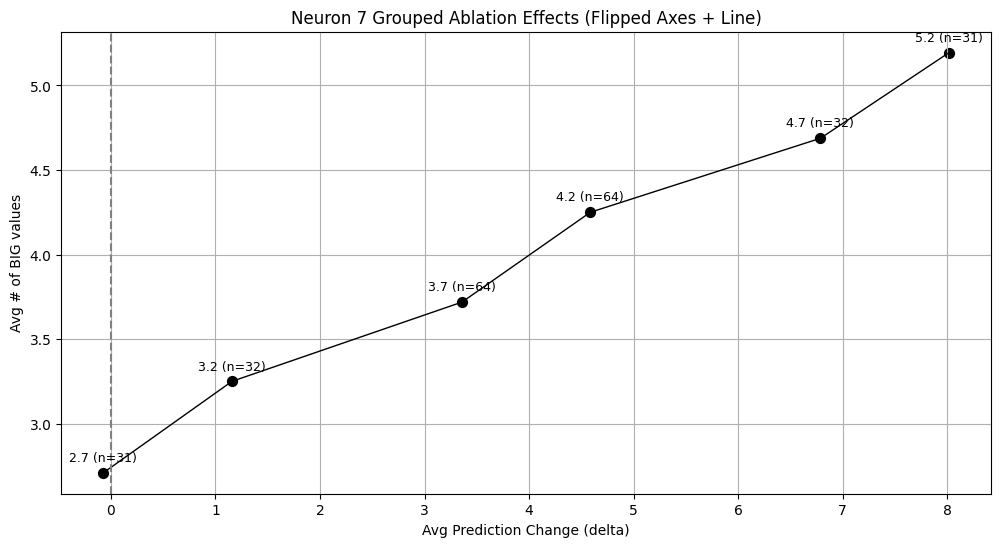

In [145]:
## note I coded a good the logic here but had chatgpt do the graphs and some clean up work
import numpy as np
import itertools
import torch

big_val = 126  # your BIG ASCII value
# all sequences of length 8 from {1, BIG}
all_combos = list(itertools.product([1, big_val], repeat=8))
X_mix = torch.tensor(all_combos, dtype=torch.float32)
# count of 1s for every sequence
num_ones = torch.tensor([seq.count(1) for seq in all_combos], dtype=torch.long)
# count of BIGs (length 8)
bigs7 = 8 - num_ones.numpy()

d7 = np.array(all_deltas[7])        # neuron 7 deltas
ones7 = np.array(num_ones.numpy())  # count of 1s
bigs7 = 8 - ones7                   # count of BIG values

pairs = sorted(zip(d7, bigs7), key=lambda x: x[0])
groups = []
current = [pairs[0]]

for i in range(1, len(pairs)):
    if abs(pairs[i][0] - current[-1][0]) <= 0.15:
        current.append(pairs[i])
    else:
        groups.append(current)
        current = [pairs[i]]

groups.append(current)

group_avgs = []
for g in groups:
    deltas = [p[0] for p in g]
    bigs   = [p[1] for p in g]
    group_avgs.append((np.mean(deltas), np.mean(bigs), len(g)))

for i, (davg, bavg, count) in enumerate(group_avgs):
    print(f"Group {i}: avg delta {davg:+.3f}, avg BIGs {bavg:.2f}, size {count}")
plt.figure(figsize=(12,6))

# sort groups by delta so the line connects in order
sorted_groups = sorted(group_avgs, key=lambda x: x[0])
line_x = [g[0] for g in sorted_groups]
line_y = [g[1] for g in sorted_groups]

plt.plot(line_x, line_y, color='black', linewidth=1)

for (davg, bavg, count) in sorted_groups:
    plt.scatter(davg, bavg, s=50, color='black')
    plt.text(davg, bavg + 0.05, f"{bavg:.1f} (n={count})",
             ha='center', va='bottom', fontsize=9)

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Avg Prediction Change (delta)")
plt.ylabel("Avg # of BIG values")
plt.title("Neuron 7 Grouped Ablation Effects (Flipped Axes + Line)")
plt.grid(True)
plt.show()




As you can see, our assumption about Neuron 7 appears to be correct: as the number of BIG values increases, removing Neuron 7 has a larger and larger average effect.

Note: the points shown here are grouped clusters, where n is the number of observations in that cluster, and the plotted value is the average number of BIG values (i.e., 8 minus the number of ones).”

# this is cool (reflection)

I learned a lot about that one neuron and how it is used.

I am surprised that we can so clearly see how it affects the model.

I wish I could understand why it does not actually seem needed when you have only a few big values and 1's. I thought it would be needed if there were any big nums.

Maybe position matters too idk, we could look into that later.